# **\[SOLAR\]** EPT + RGCN

신록예찬  
2023-07-17

# Import

In [1]:
%run 0720.py

# Load data

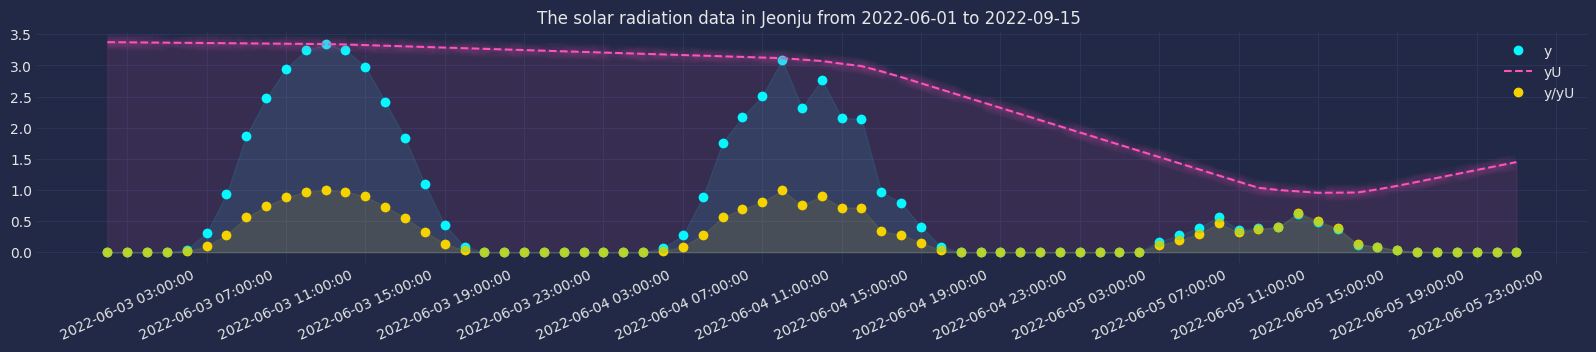

In [10]:
# read dataframe 
df = pd.read_csv('data_eng_230710.csv')

# make y, y_upper, y_period, time, regions 
y = df.loc[:,'Bukchoncheon':'Gyeongju-si'].to_numpy()
yU = df.loc[:,'Bukchoncheon_Upper':'Gyeongju-si_Upper'].to_numpy()
yP = np.divide(y, yU+1e-10)
t = df.loc[:,'date']
regions = list(df.loc[:,'Bukchoncheon':'Gyeongju-si'].columns)

# plot rawdata 
start = 50 
end = 50+24*3
city = 19 # 광주 
with plt.style.context('cyberpunk'):
    plt.rcParams['figure.figsize'] = [20, 3]  # [가로 크기, 세로 크기]
    plt.plot(t[start:end],y[start:end,city],'o',label='y')
    plt.plot(t[start:end],yU[start:end,city],'--',label='yU')
    plt.plot(t[start:end],yP[start:end,city],'o',label='y/yU')
    tick_interval = 4
    plt.xticks(range(1, len(t) + 1, tick_interval),rotation=25)        
    plt.legend()
    plt.title("The solar radiation data in {} from {} to {} ".format(regions[city],t.to_list()[0][:10],t.to_list()[-1][:10]))
    mplcyberpunk.add_glow_effects()    

# Learn

`-` y $\to$ yhat

In [3]:
# hyper params
LAGS = 4
FILTERS = 8
EPOCH = 5

# global params
TRAIN_RATIO = 0.8
T,N = len(t),len(regions) 
LEN_TEST = int(np.floor(T*(1-TRAIN_RATIO)))
LEN_TR = T - LEN_TEST

# 방법1
model = RecurrentGCN(node_features=LAGS, filters=FILTERS)
yhat = rgcn(y, model = model, train_ratio = TRAIN_RATIO, lags=LAGS, epoch=EPOCH)
yhat[yhat < 0]= 0 

# 방법2 
model = RecurrentGCN(node_features=LAGS, filters=FILTERS)
yUhat = rgcn(yU, model = model, train_ratio = TRAIN_RATIO, lags=LAGS, epoch=EPOCH)

model = RecurrentGCN(node_features=LAGS, filters=FILTERS)
yPhat = rgcn(yP, model = model, train_ratio = TRAIN_RATIO, lags=LAGS, epoch=EPOCH)
yPhat[yPhat < 0] =0 


classic = ((y - yhat)[LEN_TR:, :] ** 2)
proposed = ((y - yUhat*yPhat)[LEN_TR:, :] ** 2)

# print mse
print("""
total_mse(classic): {:.4f}
total_mse(proposed): {:.4f}
""".format(classic.mean(), proposed.mean()))

5/5
total_mse(classic): 0.0573
total_mse(proposed): 0.0476

In [4]:
# plot 
start = LEN_TR 
end = LEN_TR + LEN_TEST 
city = 20
tick_interval = 24 

classic = (y - yhat)[start:end, :] ** 2
proposed = (y - yUhat*yPhat)[start:end, :] ** 2

print("""
total_mse(classic): {:.4f}
total_mse(proposed): {:.4f}
""".format(classic.mean(), proposed.mean()))

with plt.style.context('cyberpunk'): 
    plt.rcParams['figure.figsize'] = [20, 4]  # [가로 크기, 세로 크기]
    plt.plot(t[start:end],y[start:end,city],'-',label='real')
    plt.plot(t[start:end],yhat[start:end,city],'--',label='predited(classic)')
    plt.plot(t[start:end],(yUhat*yPhat)[start:end,city],'--',label='predited(proposed)')
    plt.xticks(range(1, len(t[start:end]) + 1, tick_interval),rotation=25,ha='right')
    plt.title("The predicted results in {} from {} to {} ".format(regions[city],t[start:end].to_list()[0][:10],t[start:end].to_list()[-1][:10]))    
    plt.legend()
    mplcyberpunk.add_glow_effects()


total_mse(classic): 0.0573
total_mse(proposed): 0.0476

# Analyze

`-` y vs yhat

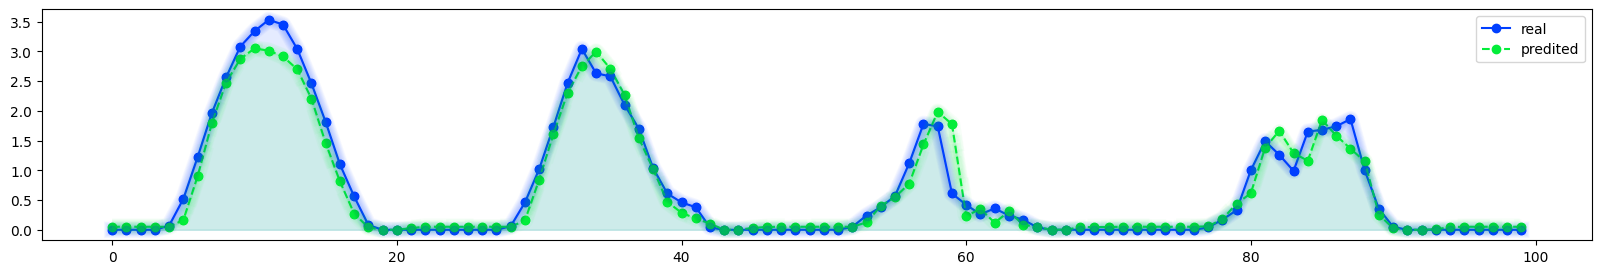

In [5]:
with plt.style.context('seaborn-bright'): 
    plt.rcParams['figure.figsize'] = [20, 3]  # [가로 크기, 세로 크기]
    plt.plot(y[50:150,0],'o-',label='real')
    plt.plot(yhat[50:150,0],'o--',label='predited')
    plt.legend()
    mplcyberpunk.add_glow_effects()    

`-` yU vs yUhat

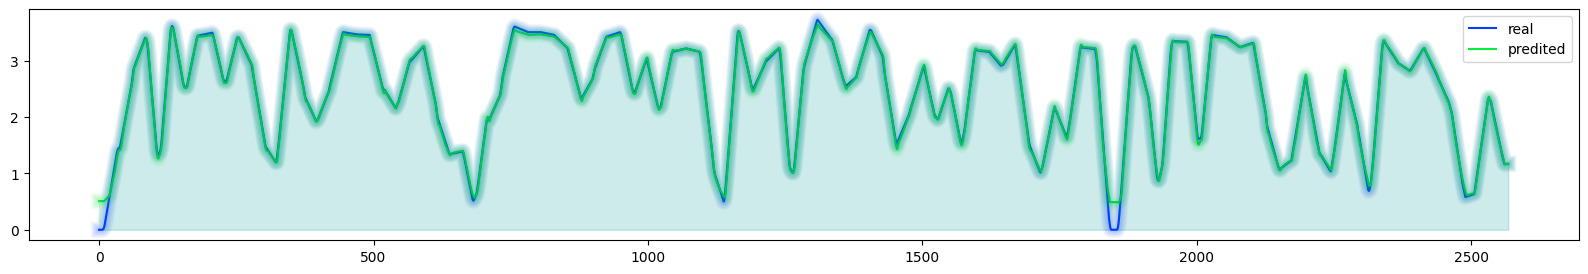

In [6]:
with plt.style.context('seaborn-bright'): 
    plt.rcParams['figure.figsize'] = [20, 3]  # [가로 크기, 세로 크기]
    plt.plot(yU[:,25],label='real')
    plt.plot(yUhat[:,25],label='predited')
    plt.legend()
    mplcyberpunk.add_glow_effects()    

`-` yP vs yPhat

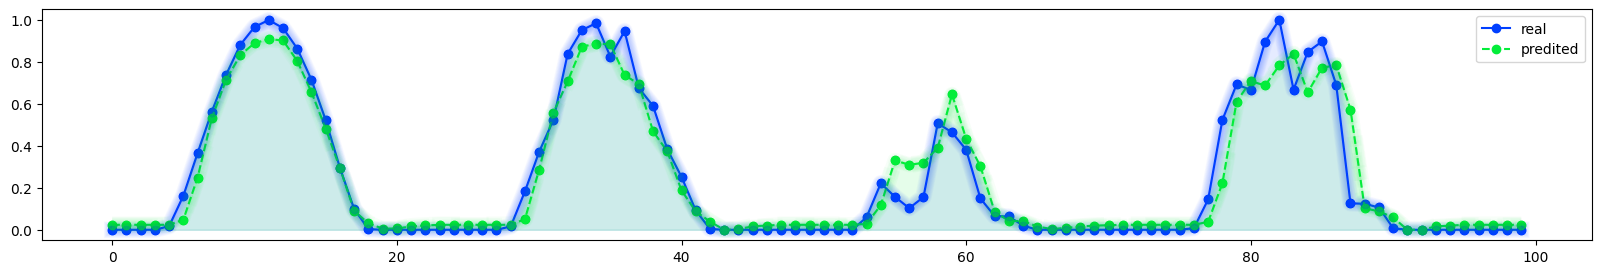

In [7]:
with plt.style.context('seaborn-bright'): 
    plt.rcParams['figure.figsize'] = [20, 3]  # [가로 크기, 세로 크기]
    plt.plot(yP[50:150,city],'o-',label='real')
    plt.plot(yPhat[50:150,city],'o--',label='predited')
    plt.legend()
    mplcyberpunk.add_glow_effects()    

`-` y vs (yUhat\*yPhat)

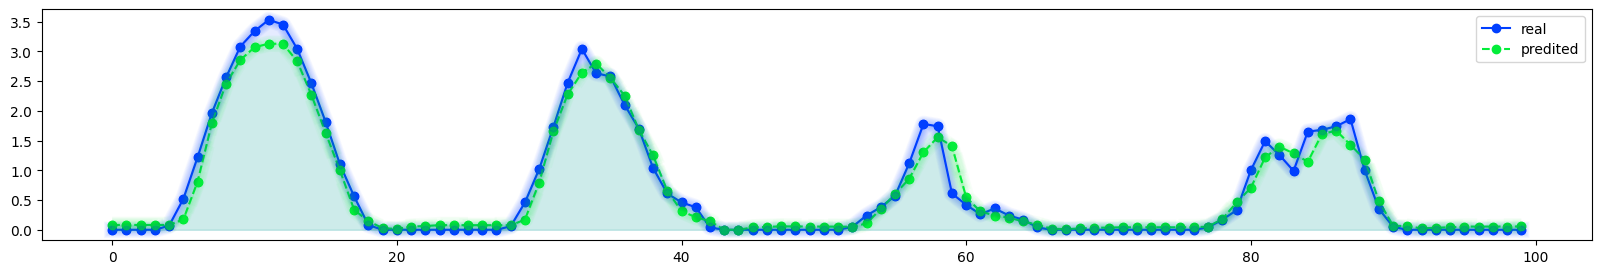

In [8]:
with plt.style.context('seaborn-bright'): 
    plt.rcParams['figure.figsize'] = [20, 3]  # [가로 크기, 세로 크기]
    plt.plot(y[50:150,0],'o-',label='real')
    plt.plot((yUhat*yPhat)[50:150,0],'o--',label='predited')
    plt.legend()
    mplcyberpunk.add_glow_effects()    

`-` 지역별분석

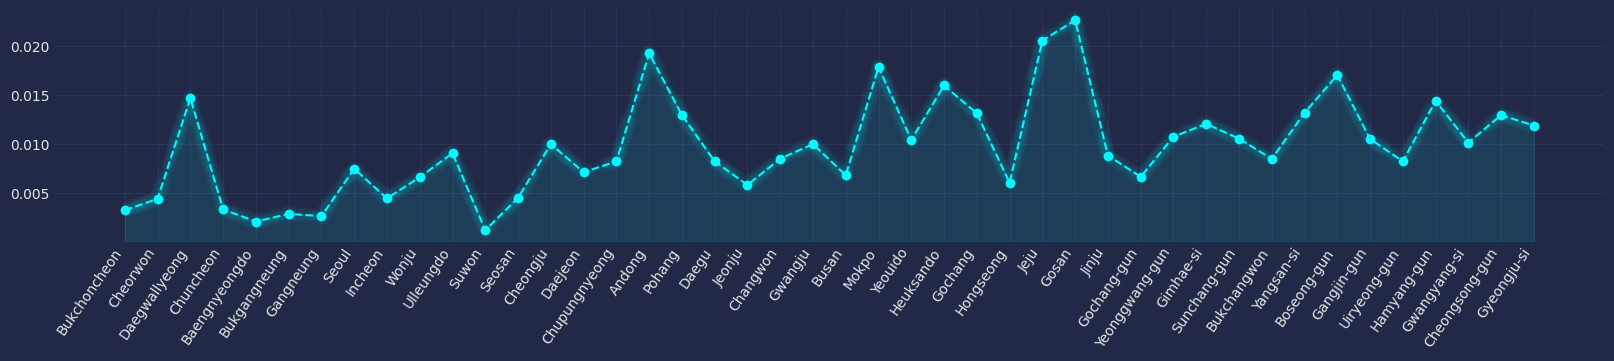

In [9]:
with plt.style.context('cyberpunk'):
    plt.rcParams['figure.figsize'] = [20, 3]  # [가로 크기, 세로 크기]
    plt.plot(regions,classic.mean(axis=0)-proposed.mean(axis=0),'--o');
    plt.xticks(regions, rotation=55, ha='right');    
    mplcyberpunk.add_glow_effects()    